# 1. SETUP AND IMPORTS

In [37]:
import logging
import os
import time
import uuid
from datetime import datetime, timedelta

# LangChain/LangGraph Components
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import MessagesState, StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from typing import List, Optional
from langchain_core.documents import Document


# Utility
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# --- Configuration ---
if not os.getenv("OPENAI_API_KEY"):
    raise ValueError("Please set your GOOGLE_API_KEY variable.")

# if not os.getenv("GOOGLE_API_KEY"):
#     raise ValueError("Please set your GOOGLE_API_KEY variable.")

# --- RAG Setup (Placeholder) ---
PDF_PATH = "data.pdf"

logging.basicConfig(
    filename='app.log',
    encoding="utf-8",
    filemode="a",
    format="%(levelname)s:%(name)s:%(message)s")

# 2 Compulsory tool: get_weather

In [38]:
@tool
def get_weather(location: str, date: Optional[str], ) -> str:
    """
    Returns weather forecast given a location and an optional date. 
    - If 'date' is provided (YYYY-MM-DD), returns forecast for that day.
    - If 'date' is OMITTED (None), AUTOMATICALLY returns forecasts for the NEXT 7 DAYS automatically.
    """
    
    # Basic Error Management: Check for missing location
    if not location:
        error_msg = "Error: Location is not provided"
        logging.error(error_msg)
        return error_msg

    today = datetime.now().date()
    if not date:
        logging.info(f"No date provided for {location}. Generating 7-day forecast.")
        reports = []
        # Loop through next 7 days
        for i in range(7):
            check_date = today + timedelta(days=i)
            date_str = check_date.strftime('%Y-%m-%d')
            # Recursive call to self to get single day
            day_report = get_weather.invoke({"location": location, "date": date_str})
            reports.append(f"- {day_report}")
        
        return "\n".join(reports)

    # Parse the date, raise error if not in the right format
    try:
        forecast_date = datetime.strptime(date, '%Y-%m-%d').date()
        today = datetime.now().date()
    except:
        error_msg = "Error: Invalid date format. The date MUST be in 'YYYY-MM-DD' format."
        logging.error(error_msg)
        return error_msg
    
    # Basic Error Management: Check if the forecast is too far in the future
    if forecast_date > today + timedelta(days=7):
        error_msg = f"Error: Forecast for {date} is too far in the future. We can only predict the weather for the next 7 days."
        logging.error(error_msg)
        return error_msg
    
    # Mocked API Logic
    if location.lower() in ["vilafranca", "sitges"] and forecast_date >= today:
        day_of_week = forecast_date.weekday()
        
        if day_of_week in [5, 6]: # Weekend
            weather = "sunny"
            temp = "28°C"
        elif day_of_week in [0, 1, 2]: # Start of week
            weather = "partly cloudy"
            temp = "25°C"
        else: # Mid-week
            weather = "light rain"
            temp = "22°C"
        logging.info("Weather data retrieved")
        return f"The weather in {location} on {date} will be **{weather}** with a high of **{temp}**."
    
    elif forecast_date < today:
        logging.info("Weather data retrieved")
        return f"Historical weather in {location} on {date}: It was a warm, sunny day."
        
    else:
        logging.info("Weather data retrieved")
        return f"Weather forecast for {location} on {date}: Data unavailable, but expect typical Spanish weather."

# List of all available tools
TOOLS = [get_weather]

# 3. RAG implementation

In [39]:
def setup_rag(pdf_path: str):
    """Loads, chunks, and indexes the PDF guide into a FAISS VectorStore."""
   
    # 1. Load Document
    try:
        loader = PyPDFLoader(pdf_path)
        docs = loader.load()
        print("Data loaded correcty")
    except Exception as e:
        print(f"Error loading PDF: {e}. Using a placeholder document.")
        docs = [{"page_content": "Vilafranca is considered the city of wine. Sitges is a beautiful coastal town known for its film festival, beaches, and historical sites like the Maricel Museum."}]
        
    # 2. Chunking Strategy (RecursiveCharacterTextSplitter is robust)
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    splits = text_splitter.split_documents(docs)
    
    # 3. Embeddings (using paraphrase-multilingual-MiniLM-L12-v2 for the multilingual approach)
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
    
    # 4. Vector Store (FAISS)
    vectorstore = FAISS.from_documents(splits, embeddings)
    
    # 5. Retriever
    retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
    print("Retriever returned correctly")
    return retriever

# Initialize the RAG Retriever
RAG_RETRIEVER = setup_rag(PDF_PATH)

Data loaded correcty
Retriever returned correctly


# 4. Model and State Definition

In [40]:
MODEL_NAME = "gemini-2.5-flash-lite"
llm = init_chat_model(
    model=MODEL_NAME,
    model_provider="google_genai", 
    temperature=0,
    max_tokens=2048
).bind_tools(TOOLS) # Bind the get_weather tool

# System Prompt to define the Agent's persona and instructions
SYSTEM_PROMPT = SystemMessage(
    content=(
        f"""You are a Tourist Assistant for Vilafranca and surrounding areas. Follow these instructions to answer the 'TRANSFORMED USER QUERY':
        **TOOL USAGE:** If the user prompt involves the weather, even when no date is specified, you MUST CALL the 'get_weather' tool, DO NOT HESITATE. Consider that today is {datetime.now().date()}
        **ANSWERING SOURCE:** Answer based *primarily* on the CONTEXT provided above, the chat history and the response of the get_weather tool (if used).  
        **CITING SOURCE:**Always cite page numbers like [Source: Page X]."""
    )
)

Since we want to be able to retrieve the context from the RAG, we add an extra field inside the State of our agent

In [41]:
class TouristAgentState(MessagesState):
    retrieved_documents: List[Document]
    transformed_query: str
    
AgentState = TouristAgentState

# 5. Nodes and edges: Graph

To allow a better performance, we will use an auxiliar llm to transform the user's query to substitue any confusing term or structure considering the chat's history

In [ ]:
REWRITE_PROMPT_TEMPLATE = \
"""You are a query resolution assistant. Your goal is to rewrite the "Latest User Query" to be a standalone sentence that can be understood without the chat history.

### Instructions:
1. **Resolve Ambiguity:** Replace pronouns (it, they, that, there) and references (the previous one, the first option) with the specific entities from the "Chat History".
2. **Preserve Details:** You must strictly PRESERVE all specific constraints, timeframes, adjectives, and conditions (e.g., "when it rains", "cheapest", "tomorrow", "in Python").
3. **No Summarization:** Do not shorten the query. Do not alter the user's intent.
4. **Identity:** If the query is already standalone, return it exactly as is.

### Examples:

Chat History:
User: Tell me about the iPhone 15.
AI: It is the latest model...

Latest User Query: How much does it cost?
Rewritten Query: How much does the iPhone 15 cost?
---
Chat History:
User: I want to visit Paris.
AI: That is a great choice.

Latest User Query: I want to go there only if it is sunny.
Rewritten Query: I want to go to Paris only if it is sunny.
---
Chat History:
User: Show me python code for a loop.
AI: Here is the code...

Latest User Query: Rewrite it in Rust.
Rewritten Query: Rewrite the python code for a loop in Rust.

### Current Conversation:

Chat History: 
{chat_history}

Latest User Query: 
{query}

Rewritten Query:"""

rewrite_prompt = ChatPromptTemplate.from_template(REWRITE_PROMPT_TEMPLATE)

MODEL_NAME = "gemini-2.5-flash-lite"
aux_llm = init_chat_model(
    model=MODEL_NAME,
    model_provider="google_genai", 
    temperature=0.3,
    max_tokens=2048,
    top_p=0.9
)

rewrite_chain = rewrite_prompt | aux_llm | StrOutputParser()

Once our rewriting feature has been defined, we have to create the main functions which will consitute the nodes of our graph: One function to rewrite the user's query, one to retrieve the information from the RAG and one to use both the query and the context to give a proper answer. (The weather node will be defined using the previously defined function)

In [43]:
def format_chat_history(messages: list) -> str:
    """Receives a list of messages corresponding to a conversation between a user (human) and an agent (ai) and returns a formatted string respresenting the last interactions"""
    history_str = ""
    for msg in messages[-10:]:
        if msg.type == "human":
            history_str += f"Human:\n{msg.content}"
        if msg.type == "ai":
            history_str += f"AI:\n{msg.content}"
    return history_str

In [44]:
def rewrite_query_node(state: AgentState) -> dict:
    """Catches last message and all previous messages in chat history and rewrites the last message into a more convenient format"""
    current_query = state['messages'][-1].content
    chat_history = format_chat_history(state['messages'][:-1])

    response = rewrite_chain.invoke({
        'query': current_query,
        'chat_history': chat_history
    })
    return {'transformed_query': response}

def retrieve_context_node(state: AgentState) -> dict:
    """Returns the most important chunkcs of information from the RAG system considering the transformed query"""
    docs = RAG_RETRIEVER.invoke(state['transformed_query'])
    return {"retrieved_documents": docs}

def agent_node(state: AgentState) -> dict:
    """Invokes the LLM considering its role, the context from the RAG system and previous messages"""
    # Content from RAG
    context_parts = [f"--Source [Page {doc.metadata['page']}] -- {doc.page_content} -- End Source --" for doc in state["retrieved_documents"]]
    context = "\n\n--- RAG Context ---\n" + "\n".join(context_parts)
    # chat hsitory
    previous_conversation = state['messages'][:-1]
    # User's original query
    user_original_query = state["messages"][-1].content
    # User's transformed query
    user_transformed_query = state["transformed_query"]
    

    combined_human_message = HumanMessage(
        content=f"""
        CONTEXT INFORMATION (RAG):
        {context}
        
        --------------------------------
        
        QUERY INFORMATION:
        - ORIGINAL USER QUERY: "{user_original_query}"
        - TRANSFORMED USER QUERY: "{user_transformed_query}"

        **CRITICAL:** You MUST answer in the language of the 'ORIGINAL USER QUERY', regardless of the language of the Context or the 'TRANSFORMED USER QUERY."""
    )
    messages_with_context = [SYSTEM_PROMPT] + previous_conversation + [combined_human_message]
    response = llm.invoke(messages_with_context)
    return {"messages": response}

In [45]:
# B. Node 2: Tool Node (weather tool)
tool_node = ToolNode(TOOLS)

# C. Define the Graph
graph_builder = StateGraph(AgentState)

# Add Nodes
graph_builder.add_node("rewriter", rewrite_query_node)
graph_builder.add_node("rag", retrieve_context_node)
graph_builder.add_node("agent", agent_node)
graph_builder.add_node("tools", tool_node)

# Set Entry Point
graph_builder.set_entry_point("rewriter")

# Define Edges/Transitions
graph_builder.add_edge("rewriter", "rag")
graph_builder.add_edge("rag", "agent")
# LangGraph's prebuilt tools_condition checks if the LLM requested a function call.
graph_builder.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "tools",  # If tool call, go to 'tools' node
        END: END,          # If no tool call, finish the conversation
    },
)

# 2. From 'tools' back to 'agent'
# After the tool runs, its output is returned to the 'agent' node for synthesis into a final answer.
graph_builder.add_edge("tools", "agent")

# Compile the graph
memory = MemorySaver() # To maintain state/context across turns
graph = graph_builder.compile(checkpointer=memory)

print("Agent graph compiled successfully.")

Agent graph compiled successfully.


# 6. EXECUTION AND DEMONSTRATION

In [46]:
# Configuration for the Agent (using a unique thread ID for multi-turn dialogue)
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

def run_agent(prompt: str, return_context=False, return_time=False, has_used_tool=False):
    time.sleep(5)
    t0 = datetime.now()
    """Helper function to run the agent and print the final output."""
    
    # Prepare the input message
    input_message = {"messages": [{"type": "user", "content": prompt}]}
    
    # Run the graph
    final_state = graph.invoke(input_message, config=config)

    # Print answer from assistant
    final_answer = final_state["messages"][-1].content
    
    duration = datetime.now() -t0
    results = {
        "answer": final_answer
    }
    if return_context:
        if final_state.get("retrieved_documents"):
            results['context'] = [doc.page_content for doc in final_state["retrieved_documents"]]
        else:
            results['context'] = []
    if return_time:
        results["duration"] = duration

    if has_used_tool:
        tool_was_called = False
        for msg in final_state["messages"]:
            if isinstance(msg, ToolMessage):
                tool_was_called = True
                break
        results['has_used_tool'] = tool_was_called

    return results 


Now the agent is fully functional, it can be asked questions about Penedes by running run_agent() and the question inside. For example you can ask:
- run_agent("I want to visit Vilafranca del Penedes, tell me something interesting about it")

In [47]:
run_agent("Quiero ir a Vilafranca. ¿Qué museos hay allí?")

{'answer': 'En Vilafranca del Penedès, puedes visitar el Convent de Sant Francesc, la Basílica de Santa Maria y el Museu del Vi [Source: Page 27]. El Museu del Vi, conocido como Vinseum, se creó en el año 2000 y se encuentra en fase de ampliación [Source: Page 9].'}

In [48]:
run_agent("¿Qué me puedes decir sobre ese museo?")

{'answer': 'El Museu del Vi, conocido como Vinseum, se creó en el año 2000 y actualmente se encuentra en fase de ampliación. Sus orígenes se remontan a casi 100 años atrás [Source: Page 9].'}

Invocación correcta (Éxito)

In [49]:
run_agent("Si quiero ir al museo cuando llueva, mañana es un buen día?")

{'answer': 'Sí, mañana es un buen día para visitar el Museu del Vi (Vinseum) si llueve, ya que el museo está ubicado en Vilafranca del Penedès y el pronóstico del tiempo para mañana indica lluvia.'}

Invocación con fallo lógico

In [50]:
run_agent("¿Y la predicción para 2030-01-01?")

{'answer': 'No tengo información sobre predicciones para el 1 de enero de 2030.'}

# 7. Metrics

We prepare a series of questions for the rag and will evaluate different metrics considering the answers and the information retrieved from the RAG

In [51]:
rag_prompts = [
    "¿Que castillos hay por el Penedés?",
    "¿Que bodegas mas famosas hay por el Penedés?",
    "En que región del Penedés/Garraf hay mas hoteles?",
    "¿Donde hay más segundas residencias en el area Penedés/Anoia/Garraf?",
    "¿Donde hay hacimientos arqueológicos en la zona Penedés/Anoia/Garraf?",
    "¿En que consiste la ruta del vino?",
    "¿Hay muchos festivales relacionados con el vino en la zona Penedés/Anoia/Garraf?",
    "¿Donde puedo acampar en Penedés/Anoia/Garraf?",
    "¿Cual es la mejor ruta caminando cerca (A 20 km máximo) de Vilafranca del Penedés?",
    "¿Que tipo de turismo es el más famoso en la zona de Penedés/Anoia/Garraf?"
]

In [52]:
tool_prompts = [
    "Que tiempo hace mañana en Sitges?",
    "Que tiempo hace mañana en Vilafranca del Penedés?",
    "Llueve dentro de tres días en Vilafranca del Penedés?",
    "Cual es el mejor día para pasear por Vilafranca del Penedés?",
    "Entre hoy y mañana cuando sería mejor hacer un plan al aire libre?"
]

## Mesure 1: Context precision:

context_precision = number of relevant chuncks (useful chuncks) / number of retrieved chunks

This metric will be evaluated manually

In [53]:
context_list = []
answer_list = []
duration_list = []
for num_prompt, prompt in enumerate(rag_prompts):
    # unique conversation for each prompt
    thread_id = str(uuid.uuid4())
    config = {"configurable": {"thread_id": thread_id}}

    # send prompt, collect answer + metadata
    result = run_agent(prompt , return_context=True, return_time=True)
    answer_list.append(result['answer'])
    context_list.append(result['context'])
    duration_list.append(result['duration'])
    print(f"For prompt #{num_prompt} {prompt} context retrieved is:\n" + "\n\n".join(["Context #" + str(num_context + 1) + ": " + single_context for num_context, single_context in enumerate(result['context'])]))

For prompt #0 ¿Que castillos hay por el Penedés? context retrieved is:
Context #1: La taula 1 permet veure la distribució d’aquests recursos per tipologies. 
El patrimoni d’aquest espai s’identifica clarament amb la funció 
defensiva: Hi trobem torres de vigilància, restes de muralles, castells i 
fortificacions escampades per tota l’àrea. Per això, Anoia Turisme ha 
centrat la seva estratègia de promoció en el concepte de ‘Terra de 
castells’ i identifica la comarca amb el seu llegat medieval. També 
Penedès Turisme identifica una sèrie de castells en la seva selecció de 
llocs d’interés, però els integra en un conjunt més ampli, amb restes 
arqueològiques, monestirs, caves i museus. És evident que els castells 
són l’element que millor defineix el passat històric d’aquest territori, 
però hi ha un elevat nombre de monuments en unes condicions que no 
permeten la visita: Espais abandonats, enrunats, integrats en un edifici 
contemporani o en alguns casos, desapareguts. Un dels princip

Summary of relevant chuncks retrieved for the answer for each prompt:

Prompt 1: 2/3

Prompt 2: 1/3

Prompt 3: 1/3

Prompt 4: 2/3

Prompt 5: 1/3

Prompt 6: 1/3

Prompt 7: 1/3

Prompt 8: 1/3

Prompt 9: 2/3

Prompt 10: 1/3


context_precision = 13/30; aprox 43%

Change chunk_size to a lower value and rerun everything and reevaluate the result manually again

## Mesure 2: Faithfuness: 

Faithfuness = number of sentences based on the retrieved information / number of sentences in the answer of the llm

We allow a llm to decide whether each sentence in the generated answer is based in any retrieved chunck.

In [54]:
assist_llm = init_chat_model(
    model=MODEL_NAME,
    model_provider="google_genai", 
    temperature=0.3,
    max_tokens=2048
)

In [55]:
system_msg = SystemMessage(content="You are an AI whose sole purpose is to decide if a sentence's affirmation is based on a series of chuncks of information. Give only the answers as 1 if True or or 0 if False.")

In [56]:
faithfuness_list = []
for idx, answer in enumerate(answer_list):
    results = []
    for sentence in answer.split("."):
        time.sleep(5)
        human_msg = HumanMessage(f"Sentence: {sentence}\nChunks of information: " + "\n".join(["Chunk #" + str(num_context + 1) + ": " + single_context for num_context, single_context in enumerate(context_list[idx])]))
        messages = [system_msg, human_msg]
        result = assist_llm.invoke(messages)
        try:
            numerical_answer = int(result.content)
            results.append(numerical_answer)
        except ValueError:
            pass 
    faithfuness = sum(results)/len(results)
    faithfuness_list.append(faithfuness)
    print(f"For prompt #{idx+1} faitfhfulness score is {faithfuness}")
print(f"Total faithfulness is {sum(faithfuness_list)/len(faithfuness_list)}")

For prompt #1 faitfhfulness score is 0.7142857142857143
For prompt #2 faitfhfulness score is 1.0
For prompt #3 faitfhfulness score is 0.75
For prompt #4 faitfhfulness score is 0.75
For prompt #5 faitfhfulness score is 1.0
For prompt #6 faitfhfulness score is 0.6666666666666666
For prompt #7 faitfhfulness score is 0.9
For prompt #8 faitfhfulness score is 0.25
For prompt #9 faitfhfulness score is 1.0
For prompt #10 faitfhfulness score is 0.8
Total faithfulness is 0.7830952380952381


## Mesure 3: RAG delay

We will visualize the ammount of time needed for the agent to deal with each prompt

In [57]:
from matplotlib import pyplot as plt

In [58]:
tokens_list = []
[tokens_list.append(llm.get_num_tokens(prompt)) for prompt in rag_prompts]

[None, None, None, None, None, None, None, None, None, None]

In [59]:
duration_list_sec = [time_.total_seconds() for time_ in duration_list]

Visualization of number of tokens in prompt vs ammount of time taken for agent to answer

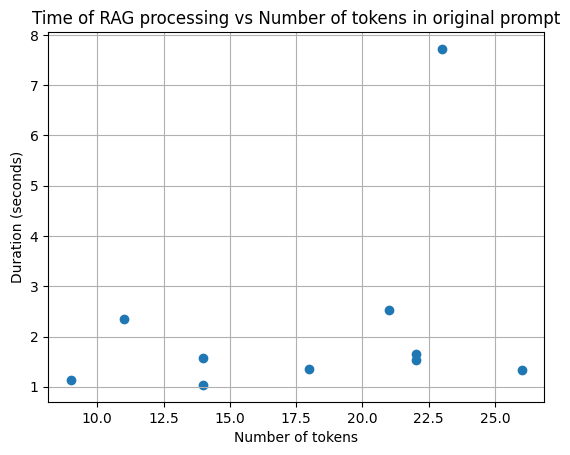

In [60]:
plt.scatter(tokens_list, duration_list_sec)
plt.xlabel('Number of tokens')
plt.ylabel('Duration (seconds)')
plt.title('Time of RAG processing vs Number of tokens in original prompt')
plt.grid(True)

plt.show()

No notice no outliers or weird behaviours

# Mesure 4: Tool usage rate

In [61]:
result_list = []
for tool_prompt in tool_prompts:
    result = run_agent(tool_prompt, has_used_tool=True)
    result_list.append(result['has_used_tool'])
print(f"Precision of correct tool calls is: {sum(result_list)/len(result_list):.2f}")
    

Precision of correct tool calls is: 1.00
